# Transfer Function Helper Tutorial

Here, we explain how to use TransferFunctionHelper to visualize and interpret yt volume rendering transfer functions.  Creating a custom transfer function is a process that usually involves some trial-and-error. TransferFunctionHelper is a utility class designed to help you visualize the probability density functions of yt fields that you might want to volume render.  This makes it easier to choose a nice transfer function that highlights interesting physical regimes.

First, we set up our namespace and define a convenience function to display volume renderings inline in the notebook.  Using `%matplotlib inline` makes it so matplotlib plots display inline in the notebook.

In [1]:
import numpy as np
from IPython.core.display import Image

import yt
from yt.visualization.volume_rendering.transfer_function_helper import (
    TransferFunctionHelper,
)

Next, we load up a low resolution Enzo cosmological simulation.

In [2]:
ds = yt.load("Enzo_64/DD0043/data0043")

yt : [INFO     ] 2025-08-13 11:10:07,123 Parameters: current_time              = 645.81707236914
yt : [INFO     ] 2025-08-13 11:10:07,123 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-08-13 11:10:07,123 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-08-13 11:10:07,124 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-08-13 11:10:07,124 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-08-13 11:10:07,124 Parameters: current_redshift          = 0.0013930880640796
yt : [INFO     ] 2025-08-13 11:10:07,124 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2025-08-13 11:10:07,124 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2025-08-13 11:10:07,125 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-08-13 11:10:07,125 Parameters: hubble_constant           = 0.71


Now that we have the dataset loaded, let's create a `TransferFunctionHelper` to visualize the dataset and transfer function we'd like to use.

In [3]:
tfh = TransferFunctionHelper(ds)

`TransferFunctionHelpler` will intelligently choose transfer function bounds based on the data values.  Use the `plot()` method to take a look at the transfer function.

Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████| 752/752 [00:00<00:00, 14192.90it/s]
yt : [INFO     ] 2025-08-13 11:10:07,204 Gathering a field list (this may take a moment.)


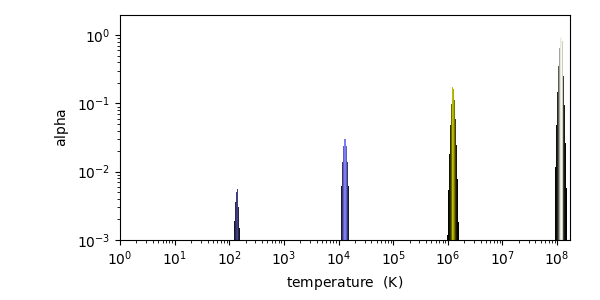

In [4]:
# Build a transfer function that is a multivariate gaussian in temperature
tfh = TransferFunctionHelper(ds)
tfh.set_field(("gas", "temperature"))
tfh.set_log(True)
tfh.set_bounds()
tfh.build_transfer_function()
tfh.tf.add_layers(5)
tfh.plot()

Let's also look at the probability density function of the `mass` field as a function of `temperature`.  This might give us an idea where there is a lot of structure. 

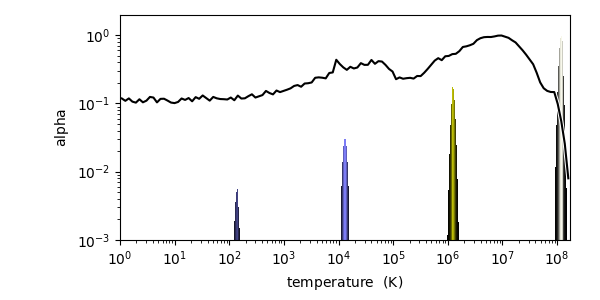

In [5]:
tfh.plot(profile_field=("gas", "mass"))

It looks like most of the gas is hot but there is still a lot of low-density cool gas.  Let's construct a transfer function that highlights both the rarefied hot gas and the dense cool gas simultaneously.

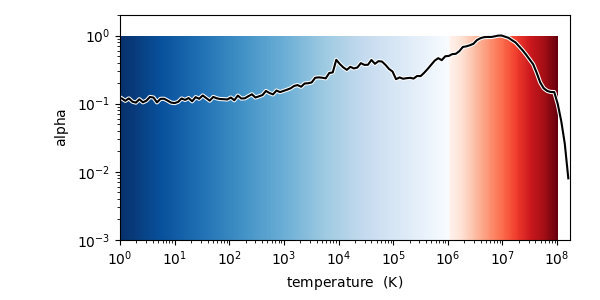

In [6]:
tfh = TransferFunctionHelper(ds)
tfh.set_field(("gas", "temperature"))
tfh.set_bounds()
tfh.set_log(True)
tfh.build_transfer_function()
tfh.tf.map_to_colormap(6.0, 8.0, colormap="Reds")
tfh.tf.map_to_colormap(-1.0, 6.0, colormap="Blues_r")

tfh.plot(profile_field=("gas", "mass"))

Let's take a look at the volume rendering. First use the helper function to create a default rendering, then we override this with the transfer function we just created.

yt : [INFO     ] 2025-08-13 11:10:08,998 Rendering scene (Can take a while).
yt : [INFO     ] 2025-08-13 11:10:08,999 Creating volume
yt : [INFO     ] 2025-08-13 11:10:10,517 Creating transfer function
yt : [INFO     ] 2025-08-13 11:10:10,517 Calculating data bounds. This may take a while. Set the TransferFunctionHelper.bounds to avoid this.
yt : [INFO     ] 2025-08-13 11:10:13,061 Found previously rendered image to save.
yt : [INFO     ] 2025-08-13 11:10:13,061 Saving rendered image to data0043_Render_temperature.png
yt : [INFO     ] 2025-08-13 11:10:13,140 Rendering scene (Can take a while).


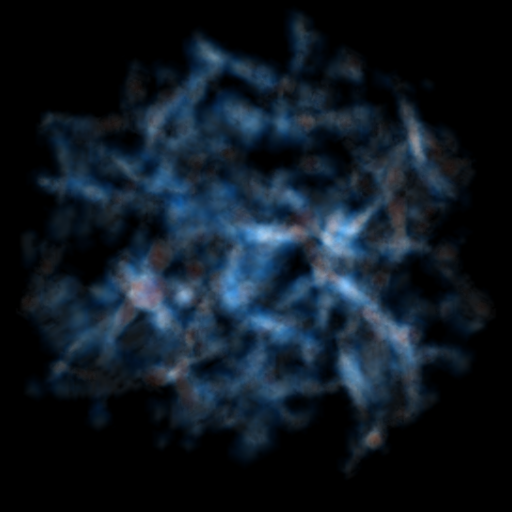

In [7]:
im, sc = yt.volume_render(ds, [("gas", "temperature")])

source = sc.get_source()
source.set_transfer_function(tfh.tf)
sc.render()
sc.show()

That looks okay, but the red gas (associated with temperatures between 1e6 and 1e8 K) is a bit hard to see in the image. To fix this, we can make that gas contribute a larger alpha value to the image by using the ``scale`` keyword argument in ``map_to_colormap``.

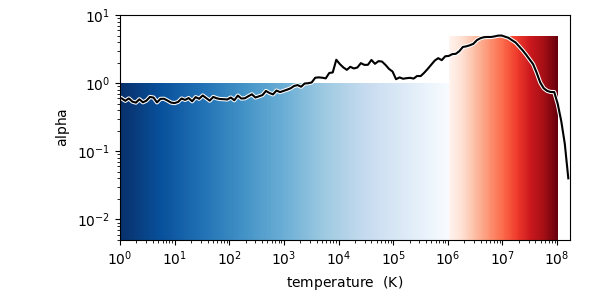

In [8]:
tfh2 = TransferFunctionHelper(ds)
tfh2.set_field(("gas", "temperature"))
tfh2.set_bounds()
tfh2.set_log(True)
tfh2.build_transfer_function()
tfh2.tf.map_to_colormap(6.0, 8.0, colormap="Reds", scale=5.0)
tfh2.tf.map_to_colormap(-1.0, 6.0, colormap="Blues_r", scale=1.0)

tfh2.plot(profile_field=("gas", "mass"))

Note that the height of the red portion of the transfer function has increased by a factor of 5.0. If we use this transfer function to make the final image:

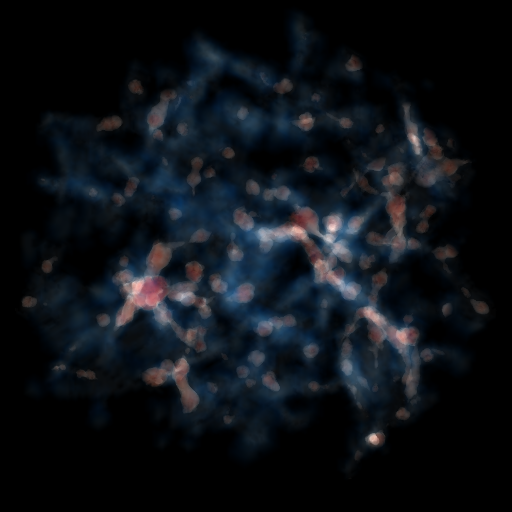

In [9]:
source.set_transfer_function(tfh2.tf)
sc.render()
sc.show()

The red gas is now much more prominent in the image. We can clearly see that the hot gas is mostly associated with bound structures while the cool gas is associated with low-density voids.